Cell 1 - Setup & Imports

In [1]:
# # @title Imports and basic setup

# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

# import math
# import matplotlib.pyplot as plt

# print("Torch version:", torch.__version__)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)


# @title Imports and setup

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__)
print("Device:", device)



Torch: 2.9.0+cu126
Device: cpu


Cell 2 - Baseline finite-volume solver

This is the classical 1D solver that generates states + fluxes.

In [2]:
# # @title Baseline finite-volume solver (1D linear advection)

# class BaselineSolver:
#     def __init__(self, nx=32, length=1.0, c=1.0, dt=1e-2, t_end=0.5):
#         """Simple 1D linear advection solver using finite-volume-style update."""
#         self.nx = nx
#         self.length = length
#         self.c = c  # advection speed
#         self.dx = length / nx
#         self.dt = dt
#         self.t_end = t_end
#         self.x = np.linspace(0.0 + 0.5*self.dx, length - 0.5*self.dx, nx)

#         # CFL check
#         if abs(self.c) * self.dt / self.dx > 1.0:
#             raise ValueError("CFL condition violated: reduce dt or increase dx.")

#     def initial_condition(self, kind="sine", seed=None):
#         rng = np.random.RandomState(seed)
#         if kind == "sine":
#             k = rng.randint(1, 4)  # mode
#             u0 = 0.5 + 0.4 * np.sin(2 * np.pi * k * self.x / self.length)
#             u0 += 0.05 * rng.randn(self.nx)
#             return u0.astype(np.float32)
#         else:
#             # fallback: random smooth-ish field
#             u0 = rng.rand(self.nx)
#             return u0.astype(np.float32)

#     def compute_flux(self, u):
#         """Compute upwind numerical fluxes at interfaces."""
#         if self.c >= 0:
#             F = self.c * u
#         else:
#             F = self.c * np.roll(u, -1)
#         return F.astype(np.float32)

#     def step(self, u):
#         """One time step of finite-volume update with periodic BC."""
#         F = self.compute_flux(u)
#         F_left = np.roll(F, 1)
#         u_next = u - (self.dt / self.dx) * (F - F_left)
#         return u_next.astype(np.float32), F

#     def run(self, u0, n_steps=10, record_flux=True):
#         states = [u0.astype(np.float32)]
#         fluxes = []
#         u = u0.astype(np.float32)
#         for _ in range(n_steps):
#             u, F = self.step(u)
#             states.append(u)
#             if record_flux:
#                 fluxes.append(F)
#         states = np.stack(states, axis=0)  # [T+1, nx]
#         if record_flux:
#             fluxes = np.stack(fluxes, axis=0)  # [T, nx]
#         else:
#             fluxes = None
#         return states, fluxes

# # quick smoke test
# solver = BaselineSolver(nx=16, dt=0.01, t_end=0.1)
# u0 = solver.initial_condition(seed=0)
# s, f = solver.run(u0, n_steps=5)
# print("Baseline smoke test: states", s.shape, "fluxes", f.shape)

# @title Fluid–Poisson BaselineSolver (toy 1D plasma)

class BaselineSolver:
    def __init__(self, nx=64, length=2*np.pi, dt=1e-2, t_end=1.0):
        """
        Simplified 1D fluid–Poisson solver:
          - evolve density n and velocity u
          - compute E from Poisson: dE/dx = n - n0 (n0=1)
        """
        self.nx = nx
        self.length = length
        self.dx = length / nx
        self.dt = dt
        self.t_end = t_end

        # cell centers
        self.x = np.linspace(0.5*self.dx, length - 0.5*self.dx, nx)
        self.n0 = 1.0  # background density

        if self.dt / self.dx > 0.5:
            print("Warning: dt/dx may be large; consider reducing dt for stability.")

        # precompute wave numbers for FFT-based Poisson solve
        k = 2.0 * np.pi * np.fft.fftfreq(nx, d=self.dx)
        self.k = k

    def initial_condition(self, seed=None):
        """
        Small sinusoidal density perturbation around n0, zero initial velocity.
        """
        rng = np.random.RandomState(seed)
        k_mode = rng.randint(1, 4)
        amp = 0.1
        n = self.n0 + amp * np.sin(k_mode * self.x)
        u = np.zeros_like(n, dtype=np.float32)
        E = self.solve_poisson(n)
        state = np.stack([n.astype(np.float32),
                          u.astype(np.float32),
                          E.astype(np.float32)], axis=0)  # [3, nx]
        return state

    def solve_poisson(self, n):
        """
        Solve dE/dx = n - n0 with periodic BC using FFT (dimensionless units).
        """
        rho = n - self.n0
        rho_hat = np.fft.fft(rho)
        k = self.k

        E_hat = np.zeros_like(rho_hat, dtype=complex)
        # For k != 0: E_hat = i * rho_hat / k (up to sign; consistent choice)
        mask = k != 0
        E_hat[mask] = 1j * rho_hat[mask] / k[mask]
        E_hat[~mask] = 0.0
        E = np.real(np.fft.ifft(E_hat))
        return E.astype(np.float32)

    def compute_flux_n(self, n, u):
        """
        Continuity flux F_n = n * u at cell centers,
        which we treat as interface flux for this toy model.
        """
        return (n * u).astype(np.float32)

    def step(self, state):
        """
        One explicit time step:
          - state: [3, nx] with (n, u, E)
          - update n via finite-volume-like flux on F_n
          - update u via explicit ODE: u^{n+1} = u^n + dt * E^n
          - recompute E^{n+1} from Poisson(n^{n+1})
        """
        n, u, E = state

        # continuity flux
        F = self.compute_flux_n(n, u)  # [nx]
        F_left = np.roll(F, 1)
        n_new = n - (self.dt / self.dx) * (F - F_left)

        # velocity update (no advection term, just E forcing)
        u_new = u + self.dt * E

        # recompute field from updated density
        E_new = self.solve_poisson(n_new)

        state_new = np.stack([n_new, u_new, E_new], axis=0).astype(np.float32)
        return state_new, F

    def run(self, state0, n_steps=10, record_flux=True):
        """
        Run the fluid–Poisson solver.
        Returns:
          states: [T+1, 3, nx]
          fluxes: [T, nx]   (continuity fluxes over time)
        """
        states = [state0.astype(np.float32)]
        fluxes = []

        state = state0.astype(np.float32)
        for _ in range(n_steps):
            state, F = self.step(state)
            states.append(state)
            if record_flux:
                fluxes.append(F)

        states = np.stack(states, axis=0)  # [T+1, 3, nx]
        if record_flux:
            fluxes = np.stack(fluxes, axis=0)  # [T, nx]
        else:
            fluxes = None
        return states, fluxes

# smoke test
solver = BaselineSolver()
s0 = solver.initial_condition(seed=0)
states, fluxes = solver.run(s0, n_steps=5)
print("Baseline fluid–Poisson: states", states.shape, "fluxes", fluxes.shape)



Baseline fluid–Poisson: states (6, 3, 64) fluxes (5, 64)


Cell 3 – Data generation

Generates training data in memory.

In [3]:
# # @title Generate training data (states + fluxes)

# def generate_dataset(
#     nx=32,
#     num_initial_conditions=4,
#     steps_per_ic=10,
#     dt=1e-2,
#     t_end=0.5,
#     c=1.0,
# ):
#     solver = BaselineSolver(nx=nx, dt=dt, t_end=t_end, c=c)
#     all_states = []
#     all_fluxes = []
#     for ic in range(num_initial_conditions):
#         u0 = solver.initial_condition(seed=ic)
#         states, fluxes = solver.run(u0, n_steps=steps_per_ic, record_flux=True)
#         # drop last state so time steps align with fluxes
#         all_states.append(states[:-1])  # [steps, nx]
#         all_fluxes.append(fluxes)       # [steps, nx]
#     all_states = np.concatenate(all_states, axis=0)  # [N, nx]
#     all_fluxes = np.concatenate(all_fluxes, axis=0)  # [N, nx]
#     x = solver.x.astype(np.float32)
#     print("Generated dataset: states", all_states.shape, "fluxes", all_fluxes.shape)
#     return all_states, all_fluxes, x

# states_all, fluxes_all, x_all = generate_dataset()


# @title Generate dataset (state_t, flux_t, state_{t+1})

def generate_dataset(
    nx=64,
    num_initial_conditions=4,
    steps_per_ic=20,
    dt=1e-2,
    t_end=1.0,
):
    solver = BaselineSolver(nx=nx, dt=dt, t_end=t_end)
    all_state_t = []
    all_flux_t = []
    all_state_next = []

    for ic in range(num_initial_conditions):
        state0 = solver.initial_condition(seed=ic)
        states, fluxes = solver.run(state0, n_steps=steps_per_ic, record_flux=True)
        # states: [steps+1, 3, nx], fluxes: [steps, nx]
        # build pairs (state_t, flux_t, state_{t+1})
        all_state_t.append(states[:-1])      # [steps, 3, nx]
        all_flux_t.append(fluxes)           # [steps, nx]
        all_state_next.append(states[1:])   # [steps, 3, nx]

    state_t = np.concatenate(all_state_t, axis=0)      # [N, 3, nx]
    flux_t = np.concatenate(all_flux_t, axis=0)        # [N, nx]
    state_next = np.concatenate(all_state_next, axis=0)  # [N, 3, nx]
    x = solver.x.astype(np.float32)

    print("Dataset shapes:")
    print(" state_t    :", state_t.shape)
    print(" flux_t     :", flux_t.shape)
    print(" state_next :", state_next.shape)
    return state_t, flux_t, state_next, x, dt, solver.dx

state_t, flux_t, state_next, x_all, dt_sim, dx_sim = generate_dataset()



Dataset shapes:
 state_t    : (80, 3, 64)
 flux_t     : (80, 64)
 state_next : (80, 3, 64)


Cell 4 - Graph constructor

Builds a 1D chain graph for each state.

In [4]:
# # @title Graph constructor (1D chain graph)

# def build_chain_graph(state, x):
#     """
#     Build a simple 1D chain graph for a given state.

#     Args:
#         state: np.ndarray [nx]
#         x: np.ndarray [nx]

#     Returns:
#         node_features: torch.FloatTensor [nx, 2] -> [state, x]
#         edge_index:   torch.LongTensor [2, 2*nx] with periodic i <-> i+1 edges
#     """
#     state = np.asarray(state, dtype=np.float32)
#     x = np.asarray(x, dtype=np.float32)
#     nx = state.shape[0]
#     node_features = torch.from_numpy(np.stack([state, x], axis=-1))  # [nx, 2]

#     src = np.arange(nx, dtype=np.int64)
#     dst = (src + 1) % nx
#     src_all = np.concatenate([src, dst], axis=0)
#     dst_all = np.concatenate([dst, src], axis=0)
#     edge_index = torch.from_numpy(np.stack([src_all, dst_all], axis=0))  # [2, 2*nx]
#     return node_features, edge_index

# node_feat_test, edge_index_test = build_chain_graph(states_all[0], x_all)
# print("Graph test: node_features", node_feat_test.shape, "edge_index", edge_index_test.shape)


# @title Graph constructor (features = [n, u, E, x])

def build_chain_graph(full_state, x):
    """
    Args:
        full_state: np.ndarray [3, nx] -> (n, u, E)
        x: np.ndarray [nx]

    Returns:
        node_features: [nx, 4] -> [n, u, E, x]
        edge_index:   [2, 2*nx] (i <-> i+1 periodic)
    """
    n = full_state[0].astype(np.float32)
    u = full_state[1].astype(np.float32)
    E = full_state[2].astype(np.float32)
    x = x.astype(np.float32)
    nx = n.shape[0]

    node_features = torch.from_numpy(
        np.stack([n, u, E, x], axis=-1)
    )  # [nx, 4]

    src = np.arange(nx, dtype=np.int64)
    dst = (src + 1) % nx
    src_all = np.concatenate([src, dst], axis=0)
    dst_all = np.concatenate([dst, src], axis=0)
    edge_index = torch.from_numpy(np.stack([src_all, dst_all], axis=0))
    return node_features, edge_index

nf_test, ei_test = build_chain_graph(state_t[0], x_all)
print("Graph test: node_features", nf_test.shape, "edge_index", ei_test.shape)



Graph test: node_features torch.Size([64, 4]) edge_index torch.Size([2, 128])


Cell 5 - FluxGNN model

In [5]:
# # @title FluxGNN model (message-passing GNN)

# class FluxGNN(nn.Module):
#     """
#     Lightweight message-passing GNN that predicts fluxes on edges of a 1D chain graph.
#     """

#     def __init__(self, in_features=2, hidden_dim=32, num_layers=2):
#         super().__init__()
#         self.input_mlp = nn.Sequential(
#             nn.Linear(in_features, hidden_dim),
#             nn.ReLU(),
#         )

#         self.update_mlps = nn.ModuleList(
#             [
#                 nn.Sequential(
#                     nn.Linear(2 * hidden_dim, hidden_dim),
#                     nn.ReLU(),
#                 )
#                 for _ in range(num_layers)
#             ]
#         )

#         self.edge_mlp = nn.Sequential(
#             nn.Linear(2 * hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1),
#         )

#     def forward(self, node_features, edge_index):
#         """
#         Args:
#             node_features: [N, F]
#             edge_index: [2, E]

#         Returns:
#             flux_pred: [E]
#         """
#         h = self.input_mlp(node_features)  # [N, H]
#         row, col = edge_index              # [E]

#         N = h.size(0)
#         for mlp in self.update_mlps:
#             agg = torch.zeros_like(h)
#             agg.index_add_(0, row, h[col])
#             deg = torch.bincount(row, minlength=N).clamp_min(1).float().unsqueeze(-1)
#             agg = agg / deg
#             h = mlp(torch.cat([h, agg], dim=-1))

#         h_row = h[row]
#         h_col = h[col]
#         edge_feat = torch.cat([h_row, h_col], dim=-1)
#         flux = self.edge_mlp(edge_feat).squeeze(-1)
#         return flux

# # smoke test
# gnn_test = FluxGNN(in_features=2, hidden_dim=16, num_layers=1)
# out_test = gnn_test(node_feat_test.float(), edge_index_test.long())
# print("FluxGNN smoke test output:", out_test.shape)


# @title FluxGNN model (in_features = 4)

class FluxGNN(nn.Module):
    def __init__(self, in_features=4, hidden_dim=64, num_layers=2):
        super().__init__()
        self.input_mlp = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
        )

        self.update_mlps = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(2 * hidden_dim, hidden_dim),
                    nn.ReLU(),
                )
                for _ in range(num_layers)
            ]
        )

        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, node_features, edge_index):
        h = self.input_mlp(node_features)
        row, col = edge_index
        N = h.size(0)

        for mlp in self.update_mlps:
            agg = torch.zeros_like(h)
            agg.index_add_(0, row, h[col])
            deg = torch.bincount(row, minlength=N).clamp_min(1).float().unsqueeze(-1)
            agg = agg / deg
            h = mlp(torch.cat([h, agg], dim=-1))

        h_row = h[row]
        h_col = h[col]
        edge_feat = torch.cat([h_row, h_col], dim=-1)
        flux = self.edge_mlp(edge_feat).squeeze(-1)
        return flux

# smoke test
gnn_test = FluxGNN()
out_test = gnn_test(nf_test.float(), ei_test.long())
print("FluxGNN smoke output:", out_test.shape)




FluxGNN smoke output: torch.Size([128])


Cell 6 - Dataset wrapper + training loop

In [6]:
# # @title Dataset wrapper and training loop

# class FluxDataset(Dataset):
#     """
#     Each item is a single time step:
#       - node_features [nx, 2]
#       - edge_index   [2, 2*nx]
#       - target_flux  [2*nx] (flux duplicated for both directions)
#     """
#     def __init__(self, states, fluxes, x):
#         assert states.shape == fluxes.shape
#         self.states = states
#         self.fluxes = fluxes
#         self.x = x
#         self.num_samples, self.nx = states.shape

#     def __len__(self):
#         return self.num_samples

#     def __getitem__(self, idx):
#         state = self.states[idx]
#         flux = self.fluxes[idx]
#         node_features, edge_index = build_chain_graph(state, self.x)
#         # tile per-interface flux onto directed edges
#         flux_edge = np.concatenate([flux, flux], axis=0).astype(np.float32)
#         return node_features, edge_index, torch.from_numpy(flux_edge)

# def collate_fn(batch):
#     # one sample per batch in this scaffold
#     return batch[0]

# def train_model(
#     states,
#     fluxes,
#     x,
#     epochs=5,
#     lr=1e-3,
#     hidden_dim=32,
#     num_layers=2,
#     device=device,
# ):
#     dataset = FluxDataset(states, fluxes, x)
#     loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

#     model = FluxGNN(in_features=2, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
#     crit = nn.MSELoss()
#     opt = optim.Adam(model.parameters(), lr=lr)

#     model.train()
#     for epoch in range(1, epochs+1):
#         total = 0.0
#         for node_features, edge_index, flux_edge in loader:
#             node_features = node_features.to(device)
#             edge_index = edge_index.to(device)
#             flux_edge = flux_edge.to(device)

#             opt.zero_grad()
#             pred = model(node_features, edge_index)
#             loss = crit(pred, flux_edge)
#             loss.backward()
#             opt.step()
#             total += loss.item()

#         print(f"[Train] Epoch {epoch}/{epochs} - Loss: {total/len(loader):.6e}")
#     return model

# print("Training FluxGNN...")
# model_trained = train_model(states_all, fluxes_all, x_all, epochs=5)



# @title Dataset wrapper + physics-informed training loop

class FluxDataset(Dataset):
    """
    Each sample:
      - state_t      [3, nx]
      - flux_t       [nx]
      - state_next   [3, nx]
    """
    def __init__(self, state_t, flux_t, state_next, x):
        assert state_t.shape == state_next.shape
        assert state_t.shape[0] == flux_t.shape[0]
        self.state_t = state_t       # [N, 3, nx]
        self.flux_t = flux_t         # [N, nx]
        self.state_next = state_next # [N, 3, nx]
        self.x = x
        self.N, self.C, self.nx = state_t.shape

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return (
            self.state_t[idx],       # [3, nx]
            self.flux_t[idx],        # [nx]
            self.state_next[idx],    # [3, nx]
        )

def collate_fn(batch):
    # 1 sample per batch (keeps things simple & clear)
    return batch[0]

# Helper: Poisson solve on torch tensors (for E_mse)
def solve_poisson_torch(n, n0, dx, device=device):
    """
    n: [nx] torch
    returns E: [nx] torch
    """
    nx = n.shape[0]
    rho = n - n0
    rho_np = rho.detach().cpu().numpy()
    k = 2.0 * np.pi * np.fft.fftfreq(nx, d=dx)
    rho_hat = np.fft.fft(rho_np)
    E_hat = np.zeros_like(rho_hat, dtype=complex)
    mask = k != 0
    E_hat[mask] = 1j * rho_hat[mask] / k[mask]
    E_hat[~mask] = 0.0
    E_np = np.real(np.fft.ifft(E_hat)).astype(np.float32)
    return torch.from_numpy(E_np).to(device)

def train_model(
    state_t,
    flux_t,
    state_next,
    x,
    dt,
    dx,
    epochs=10,
    lr=1e-3,
    hidden_dim=64,
    num_layers=2,
    device=device,
    lambda_state=1.0,
    lambda_poisson=0.1,
):
    dataset = FluxDataset(state_t, flux_t, state_next, x)
    loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

    model = FluxGNN(in_features=4, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    n0 = 1.0  # background

    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        for st, ft, st_next in loader:
            # numpy -> torch
            st = torch.from_numpy(st).float().to(device)        # [3, nx]
            ft_true = torch.from_numpy(ft).float().to(device)   # [nx]
            st_next_true = torch.from_numpy(st_next).float().to(device)

            n_t = st[0]       # [nx]
            u_t = st[1]
            E_t = st[2]
            n_next_true = st_next_true[0]   # [nx]
            E_next_true = st_next_true[2]

            node_features, edge_index = build_chain_graph(st.cpu().numpy(), x)
            node_features = node_features.to(device)
            edge_index = edge_index.to(device)

            # forward: predict edge fluxes, average to cell-centered
            flux_edge = model(node_features, edge_index)  # [2*nx]
            nx = n_t.shape[0]
            F_forward = flux_edge[:nx]
            F_backward = flux_edge[nx:]
            F_pred = 0.5 * (F_forward + F_backward)       # [nx]

            # 1) supervised flux loss
            flux_loss = mse(F_pred, ft_true)

            # 2) one-step density update with predicted flux
            F_left_pred = torch.roll(F_pred, 1)
            n_next_pred = n_t - (dt/dx) * (F_pred - F_left_pred)
            state_loss = mse(n_next_pred, n_next_true)

            # 3) Poisson consistency: E(n_next_pred) vs E_next_true
            E_next_pred = solve_poisson_torch(n_next_pred, n0=n0, dx=dx, device=device)
            poisson_loss = mse(E_next_pred, E_next_true)

            loss = flux_loss + lambda_state*state_loss + lambda_poisson*poisson_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Train] Epoch {epoch}/{epochs} - Loss: {total_loss/len(loader):.6e}")

    return model

print("Training FluxGNN with physics-informed losses...")
model_trained = train_model(
    state_t,
    flux_t,
    state_next,
    x_all,
    dt_sim,
    dx_sim,
    epochs=10,
    lr=1e-3,
    hidden_dim=64,
    num_layers=2,
    lambda_state=1.0,
    lambda_poisson=0.1,
)



Training FluxGNN with physics-informed losses...
[Train] Epoch 1/10 - Loss: 3.402905e-04
[Train] Epoch 2/10 - Loss: 2.401932e-05
[Train] Epoch 3/10 - Loss: 1.947691e-05
[Train] Epoch 4/10 - Loss: 1.550174e-05
[Train] Epoch 5/10 - Loss: 1.266822e-05
[Train] Epoch 6/10 - Loss: 1.100373e-05
[Train] Epoch 7/10 - Loss: 1.046256e-05
[Train] Epoch 8/10 - Loss: 9.318797e-06
[Train] Epoch 9/10 - Loss: 9.290183e-06
[Train] Epoch 10/10 - Loss: 9.049675e-06


Cell 7 – Hybrid solver + evaluation

This plugs the trained GNN into a classical time loop and compares to the baseline.

Evaluating baseline vs hybrid...
Trajectory MSE (density n): 1.5925971e-06


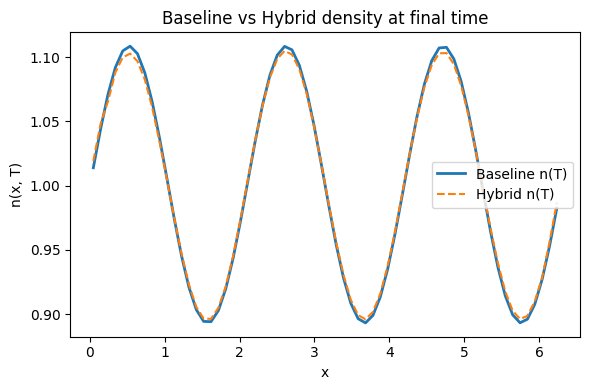

In [7]:
# # @title Hybrid solver and evaluation

# class HybridSolver:
#     """
#     Hybrid solver: classical finite-volume update, but flux from trained GNN.
#     """
#     def __init__(self, model, nx=32, length=1.0, c=1.0, dt=1e-2, t_end=0.5, device=device):
#         self.baseline = BaselineSolver(nx=nx, length=length, c=c, dt=dt, t_end=t_end)
#         self.model = model.to(device)
#         self.model.eval()
#         self.device = device

#     def step(self, u):
#         state = u.astype(np.float32)
#         node_features, edge_index = build_chain_graph(state, self.baseline.x)
#         node_features = node_features.to(self.device)
#         edge_index = edge_index.to(self.device)
#         with torch.no_grad():
#             flux_edge = self.model(node_features, edge_index).cpu().numpy()  # [2*nx]

#         nx = self.baseline.nx
#         F_forward = flux_edge[:nx]
#         F_backward = flux_edge[nx:]
#         F = 0.5 * (F_forward + F_backward).astype(np.float32)

#         F_left = np.roll(F, 1)
#         u_next = state - (self.baseline.dt / self.baseline.dx) * (F - F_left)
#         return u_next.astype(np.float32), F

#     def run(self, u0, n_steps=10):
#         states = [u0.astype(np.float32)]
#         fluxes = []
#         u = u0.astype(np.float32)
#         for _ in range(n_steps):
#             u, F = self.step(u)
#             states.append(u)
#             fluxes.append(F)
#         states = np.stack(states, axis=0)
#         fluxes = np.stack(fluxes, axis=0)
#         return states, fluxes

# print("Evaluating baseline vs hybrid...")

# nx = 32
# dt = 1e-2
# t_end = 0.5
# c = 1.0
# n_steps = 20

# baseline_eval = BaselineSolver(nx=nx, dt=dt, t_end=t_end, c=c)
# u0_eval = baseline_eval.initial_condition(seed=42)
# states_b, _ = baseline_eval.run(u0_eval, n_steps=n_steps)

# hybrid_eval = HybridSolver(model_trained, nx=nx, dt=dt, t_end=t_end, c=c)
# states_h, _ = hybrid_eval.run(u0_eval, n_steps=n_steps)

# mse = np.mean((states_b - states_h)**2)
# print("Final Baseline vs Hybrid MSE:", mse)

# # Plot final state comparison
# x = baseline_eval.x
# plt.figure(figsize=(6,4))
# plt.plot(x, states_b[-1], label="Baseline final", linewidth=2)
# plt.plot(x, states_h[-1], label="Hybrid final", linestyle="--")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("u(x, t_end)")
# plt.title("Baseline vs Hybrid final state")
# plt.tight_layout()
# plt.show()



# @title Hybrid solver using learned flux + evaluation

class HybridSolver:
    """
    Hybrid solver:
      - same grid & dt as BaselineSolver
      - continuity flux from trained GNN
      - u updated via E, E recomputed via Poisson(n)
    """
    def __init__(self, model, nx=64, length=2*np.pi, dt=1e-2, t_end=1.0, device=device):
        self.baseline = BaselineSolver(nx=nx, length=length, dt=dt, t_end=t_end)
        self.model = model.to(device)
        self.model.eval()
        self.device = device

    def step(self, state):
        """
        state: [3, nx] numpy
        """
        n, u, E = state
        # build graph from current state
        node_features, edge_index = build_chain_graph(state, self.baseline.x)
        node_features = node_features.to(self.device)
        edge_index = edge_index.to(self.device)

        with torch.no_grad():
            flux_edge = self.model(node_features, edge_index).cpu().numpy()

        nx = self.baseline.nx
        F_forward = flux_edge[:nx]
        F_backward = flux_edge[nx:]
        F_pred = 0.5 * (F_forward + F_backward).astype(np.float32)

        # continuity update
        F_left = np.roll(F_pred, 1)
        n_new = n - (self.baseline.dt/self.baseline.dx) * (F_pred - F_left)

        # velocity update with E (same as baseline)
        u_new = u + self.baseline.dt * E

        # recompute E from updated density
        E_new = self.baseline.solve_poisson(n_new)

        state_new = np.stack([n_new, u_new, E_new], axis=0).astype(np.float32)
        return state_new

    def run(self, state0, n_steps=20):
        states = [state0.astype(np.float32)]
        state = state0.astype(np.float32)
        for _ in range(n_steps):
            state = self.step(state)
            states.append(state)
        states = np.stack(states, axis=0)   # [T+1, 3, nx]
        return states

print("Evaluating baseline vs hybrid...")

nx = 64
dt = dt_sim
t_end = 1.0
n_steps_eval = 40

baseline_eval = BaselineSolver(nx=nx, dt=dt, t_end=t_end)
state0_eval = baseline_eval.initial_condition(seed=123)
states_b, _ = baseline_eval.run(state0_eval, n_steps=n_steps_eval)

hybrid_eval = HybridSolver(model_trained, nx=nx, dt=dt, t_end=t_end)
states_h = hybrid_eval.run(state0_eval, n_steps=n_steps_eval)

# Compare density trajectories
n_b = states_b[:, 0, :]   # [T+1, nx]
n_h = states_h[:, 0, :]   # [T+1, nx]

mse_traj = np.mean((n_b - n_h)**2)
print("Trajectory MSE (density n):", mse_traj)

# Plot final density profile
x = baseline_eval.x
plt.figure(figsize=(6,4))
plt.plot(x, n_b[-1], label="Baseline n(T)", linewidth=2)
plt.plot(x, n_h[-1], label="Hybrid n(T)", linestyle="--")
plt.xlabel("x")
plt.ylabel("n(x, T)")
plt.title("Baseline vs Hybrid density at final time")
plt.legend()
plt.tight_layout()
plt.show()
